# Avazu CTR广告点击率预测（lightGBM）

* Content：对Netflix数据集进行评分预测
* Author:  HuiHui
* Date:    2020-06-01
* Reference:https://www.kaggle.com/c/avazu-ctr-prediction

## 提交说明

* 采用的模型:lightgbm
* score:0.41693

## Avazu数据集

* **训练集：**10天的点击数据，按时间顺序排列。根据不同的策略对非点击和点击进行二次采样。
* **测试集：** 1天的广告用于测试模型   
* **提交文件：**
* **字段：**  
&emsp;**click:** 0-不点击，1-点击   
&emsp;**C1，C14-C21：**匿名分类变量  
&emsp;**hour:** 格式为YYMMDDHH

## 导入相关库

In [6]:
# !/usr/bin/env python
# -*- coding=utf-8 -*-
import pandas as pd
import numpy as np
import random
import pickle  # 存储临时变量
from tqdm import tqdm
import gc

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") # 忽略警告信息

import sklearn
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from dummyPy import OneHotEncoder

from sklearn.linear_model import SGDClassifier  # 梯度下降分类
import lightgbm as lgb

## 数据预处理

* 特征选择  
* 绘制分类数据分布图
* 将所有不常用的分类转换成'other'
* LabelEncoder、OneHotEncoder
* 下采样训练样本

loading data...


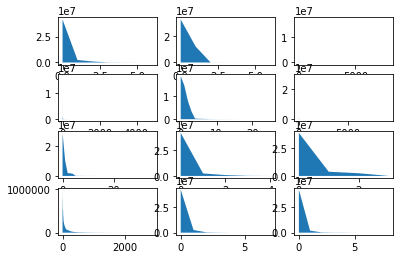

In [2]:
## 读文件
# file_path = '/Users/wangdonghui/Desktop/ZGZ/RS/dataset/avazu-ctr-prediction/' # mac路径
file_path = 'C:/Users/Administrator/Desktop/W/DataSet/avazu/' # win路径
fp_train = file_path + 'train.csv'
fp_test  = file_path + 'test.csv'

## 下采样写文件
fp_sub_train_f = file_path + 'sub_train_f.csv'
fp_col_counts = file_path + 'col_counts'

## data after selecting features (LR_fun needed)
## and setting rare categories' value to 'other' (feature filtering)
fp_train_f = file_path + 'train_f.csv'
fp_test_f  = file_path + 'test_f.csv'

## 存储标签编码和one-hot编码
fp_lb_enc = file_path + 'lb_enc'
fp_oh_enc = file_path + 'oh_enc'

##==================== 数据预处理 ====================##
# 特征选择
cols = ['C1', 
        'banner_pos', 
        'site_domain', 
        'site_id',
        'site_category',
        'app_id',
        'app_category', 
        'device_type', 
        'device_conn_type',
        'C14', 
        'C15',
        'C16']

cols_train = ['id', 'click']
cols_test  = ['id']
cols_train.extend(cols)
cols_test.extend(cols)

## 数据加载
print('loading data...')
df_train_ini = pd.read_csv(fp_train, nrows = 10)# nrows = 10读取一个大文件中的几行数据
df_train_org = pd.read_csv(fp_train, chunksize = 10000000, iterator = True)# 分块读取,iterator = True返回一个可迭代对象TextFileReader,reader.get_chunk(5)返回前五条数据
df_test_org  = pd.read_csv(fp_test,  chunksize = 10000000, iterator = True)

# print(df_train_ini.head())
# print("=="*50)
# print(df_train_org.get_chunk(5))
# print("=="*50)
# print(df_test_org.get_chunk(5))

#----- 统计分类变量 数值个数 -----#
## 初始化
cols_counts = {}  # 统计每个特征的分类数量
for col in cols:
    cols_counts[col] = df_train_ini[col].value_counts()

## 统计训练集
for chunk in df_train_org:
    for col in cols:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())   

## 统计测试集
for chunk in df_test_org:
    for col in cols:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())

## 统计      ==============================> ??? 多统计了一次df_train_ini的特征
for col in cols:
    cols_counts[col] = cols_counts[col].groupby(cols_counts[col].index).sum()
    # sort the counts
    cols_counts[col] = cols_counts[col].sort_values(ascending=False)   

## 存储value_counting
pickle.dump(cols_counts, open(fp_col_counts, 'wb'))

## 绘制分布
fig = plt.figure(1)
for i, col in enumerate(cols):
    ax = fig.add_subplot(4, 3, i+1)
    ax.fill_between(np.arange(len(cols_counts[col])), cols_counts[col].get_values())
    # ax.set_title(col)
plt.show()

In [3]:
## 只保存前K个分类变量
k = 99
col_index = {}
for col in cols:
    col_index[col] = cols_counts[col][0: k].index

df_train_org = pd.read_csv(fp_train, dtype = {'id': str}, chunksize = 10000000, iterator = True)
df_test_org  = pd.read_csv(fp_test,  dtype = {'id': str}, chunksize = 10000000, iterator = True)

## 训练集
hd_flag = True  # add column names at 1-st row
for chunk in df_train_org:
    df = chunk.copy()
    for col in cols:
        df[col] = df[col].astype('object')
        # 将所有稀有的分类转换成'other'
        df.loc[~df[col].isin(col_index[col]), col] = 'other'    ####？？？？？？
    with open(fp_train_f, 'a') as f:
        df.to_csv(f, columns = cols_train, header = hd_flag, index = False)
    hd_flag = False

## 测试集
hd_flag = True  # 第一个chunk需要有header
for chunk in df_test_org:
    df = chunk.copy()
    for col in cols:
        df[col] = df[col].astype('object')
        # 设置其他不常用变量为other
        df.loc[~df[col].isin(col_index[col]), col] = 'other'
    with open(fp_test_f, 'a') as f:
        df.to_csv(f, columns = cols_test, header = hd_flag, index = False)      
    hd_flag = False    

print("ok")

ok


In [4]:
## 对分类变量进行标签编码
lb_enc = {}
for col in cols:
    col_index[col] = np.append(col_index[col], 'other')

for col in cols:
    lb_enc[col] = LabelEncoder()
    lb_enc[col].fit(col_index[col])
    
## 存储标签编码
pickle.dump(lb_enc, open(fp_lb_enc, 'wb'))

## one-hot编码
oh_enc = OneHotEncoder(cols)

df_train_f = pd.read_csv(fp_train_f, index_col=None, chunksize=5000000, iterator=True)
df_test_f  = pd.read_csv(fp_test_f, index_col=None, chunksize=5000000, iterator=True)

for chunk in df_train_f:
    oh_enc.fit(chunk)
for chunk in df_test_f:
    oh_enc.fit(chunk)
    
## 存储one-hot编码
pickle.dump(oh_enc, open(fp_oh_enc, 'wb'))

print("ok")

ok


In [ ]:
# 计算总训练样本 约46M
n = sum(1 for line in open(fp_train_f)) - 1 
# 保存下采样训练样本 2M
s = 2000000

## 设置哪些行不需要读 skip，不需要读的行数为n-s
skip = sorted(random.sample(range(1, n+1), n-s)) 
df_train = pd.read_csv(fp_train_f, skiprows = skip)
df_train.columns = cols_train

## 存储下采样的结果
df_train.to_csv(fp_sub_train_f, index=False) 

print("ok")

## CTR预测（LR）

training...
training...
LR model saved
[0.5902272122294253, 0.5590883409976604]


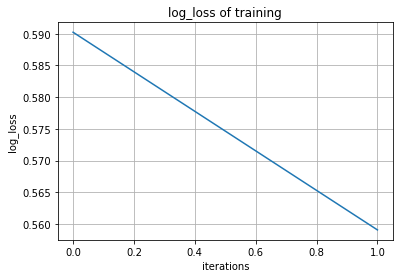

predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predicting...
predic

In [9]:
##==================== 设置文件路径File-Path (fp) ====================##
file_path = '/Users/wangdonghui/Desktop/ZGZ/RS/dataset/avazu-ctr-prediction/' # mac路径
# file_path = 'C:/Users/Administrator/Desktop/W/DataSet/avazu/' # win路径

# 全量样本
fp_train_f = file_path + "train_f.csv"
# 小样本
fp_sub_train_f = file_path + 'sub_train_f.csv'

fp_test_f  = file_path + "test_f.csv"

# one-hot编码保存
fp_oh_enc = file_path + "oh_enc"
# LR模型保存
fp_lr_model = file_path + "lr/lr_model"
# submission文件保存
fp_sub = file_path + "lr/LR_submission.csv"

##==================== LR模型 训练 ====================##
oh_enc = pickle.load(open(fp_oh_enc, 'rb'))

# 一个chunk块为5万行
chunksize = 50000
# df_train_f = pd.read_csv(fp_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取全量样本
df_train_f = pd.read_csv(fp_sub_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取小样本
# print(df_train_f.get_chunk(5))

# 使用LogLoss作为LR的损失函数
lr_model = SGDClassifier(loss='log')  
scores = []

# 使用k和i调整训练规模，训练样本 = 所有样本 / k
k = 20 #100  
i = 1
for chunk in df_train_f:
    # 根据K drop掉样本
    if i < k: 
        i += 1
        continue
    print('training...')
    i = 1
    df_train = oh_enc.transform(chunk)
    # LR训练
    feature_train = df_train.columns.drop(['id', 'click'])
    train_X = df_train[feature_train]
    train_y = df_train['click'].astype('int')
    lr_model.partial_fit(train_X, train_y, classes = [0,1])  # fitting
    
    # 训练结果logloss分数
    y_pred = lr_model.predict_proba(train_X)[:, 1]
    score = log_loss(train_y, y_pred)
    scores.append(score)

## 存储训练好的LR模型
pickle.dump(lr_model, open(fp_lr_model, 'wb'))
print('LR model saved')

print(scores)
#scores = [0.1, 0.2, 0.3, 0.4]
## 绘制LR训练分数曲线
#f1 = plt.figure(1)
plt.title("LR Training Curve") 
plt.plot(scores)
plt.xlabel('iterations')
plt.ylabel('log_loss')
plt.title('log_loss of training')
plt.grid()
plt.show()

import gc
del lr_model
del df_train_f
gc.collect()

##==================== 使用训练好的LR模型进行预测，提交submission ====================##
df_test_f = pd.read_csv(fp_test_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True)        
lr_model = pickle.load(open(fp_lr_model, 'rb'))

# 按照chunk对测试集进行预测
header = True
for chunk in df_test_f:
    print('predicting...')
    df_test = oh_enc.transform(chunk)
    # 去掉ID字段
    feature_test = df_test.columns.drop(['id'])
    test_X = df_test[feature_test]
    # 计算class=1的概率
    y_pred = lr_model.predict_proba(test_X)[:, 1]  
    # 得到submittion
    chunk['click'] = y_pred
    with open(fp_sub, 'a') as f: 
        # 只有第一次header=True，其余header=False
        chunk.to_csv(f, columns=['id', 'click'], header=header, index=False) 
    header = False

print('submittion completed')

## CTR预测（lightGBM）


0it [00:00, ?it/s]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6447, number of negative: 33553
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.161175 -> initscore=-1.649511
[LightGBM] [Info] Start training from score -1.649511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit


1it [00:04,  4.26s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6578, number of negative: 33422
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[Light


2it [00:07,  3.93s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7806, number of negative: 32194
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


3it [00:10,  3.75s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7347, number of negative: 32653
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


4it [00:14,  3.85s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6936, number of negative: 33064
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


5it [00:20,  4.48s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6271, number of negative: 33729
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


6it [00:27,  5.22s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 5605, number of negative: 34395
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


7it [00:34,  5.76s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 5916, number of negative: 34084
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


8it [00:43,  6.54s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6907, number of negative: 33093
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 116
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


9it [00:51,  7.22s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7285, number of negative: 32715
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warnin


10it [01:01,  7.92s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7016, number of negative: 32984
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


11it [01:12,  8.90s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7900, number of negative: 32100
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warnin


12it [01:24,  9.93s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6958, number of negative: 33042
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


13it [01:39, 11.40s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7055, number of negative: 32945
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


14it [01:54, 12.50s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7051, number of negative: 32949
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 124
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


15it [02:11, 13.87s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7298, number of negative: 32702
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


16it [02:33, 16.07s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6439, number of negative: 33561
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


17it [02:55, 17.90s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7399, number of negative: 32601
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


18it [03:21, 20.53s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7686, number of negative: 32314
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warnin


19it [03:47, 21.92s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7165, number of negative: 32835
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warnin


20it [04:20, 25.41s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7603, number of negative: 32397
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warnin


21it [04:45, 25.31s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7281, number of negative: 32719
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warnin


22it [05:10, 25.15s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7387, number of negative: 32613
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


23it [05:35, 25.12s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6876, number of negative: 33124
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warnin


24it [06:02, 25.65s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7356, number of negative: 32644
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 120
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warnin


25it [06:29, 26.03s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7674, number of negative: 32326
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warnin


26it [06:56, 26.41s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6623, number of negative: 33377
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


27it [07:24, 26.87s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6764, number of negative: 33236
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 122
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


28it [07:56, 28.49s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 5393, number of negative: 34607
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 123
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


29it [08:30, 29.94s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 5897, number of negative: 34103
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


30it [09:04, 31.23s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6313, number of negative: 33687
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


31it [09:39, 32.36s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 5739, number of negative: 34261
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warnin


32it [10:15, 33.49s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6360, number of negative: 33640
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warnin


33it [10:51, 34.27s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 5942, number of negative: 34058
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


34it [11:30, 35.48s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6430, number of negative: 33570
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


35it [12:09, 36.73s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6705, number of negative: 33295
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 125
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


36it [12:51, 38.34s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 5563, number of negative: 34437
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warnin


37it [13:34, 39.74s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6983, number of negative: 33017
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


38it [14:17, 40.76s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 6794, number of negative: 33206
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


39it [15:01, 41.62s/it]

training...
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 7452, number of negative: 32548
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] No further splits with positive g


40it [15:45, 23.64s/it]


lightGBM model saved
[0.4025619539313211, 0.39848299706511386, 0.45876933934588576, 0.44945105992441897, 0.41891535477250336, 0.405087355600715, 0.37124856934452055, 0.38389991079665503, 0.4299829444873887, 0.4504867047187704, 0.4311169879840305, 0.46498330527696624, 0.42623231591821625, 0.4365806747605638, 0.4443508503666824, 0.42761524731747286, 0.4126297463226291, 0.42837273424096145, 0.45024447270470536, 0.427126704439364, 0.45475264534295184, 0.43286942390505617, 0.4401580862189812, 0.41607098014392413, 0.4287517999220348, 0.4429622230295661, 0.4294981318672918, 0.40910563315336423, 0.370013630413484, 0.3744463426989907, 0.3981305930111375, 0.3654914138329908, 0.4009687700407489, 0.3792802375297412, 0.4100185465120636, 0.4218143221290017, 0.37768230366326694, 0.43045533478163417, 0.4087539318685966, 0.44854715890157687]


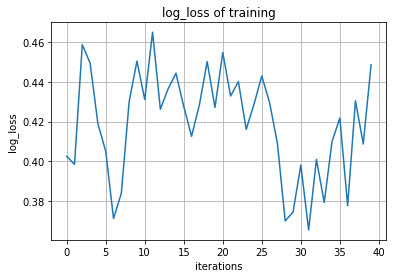

5956

In [7]:
##==================== 设置文件路径File-Path (fp) ====================##
file_path = '/Users/wangdonghui/Desktop/ZGZ/RS/dataset/avazu-ctr-prediction/' # mac路径
# file_path = 'C:/Users/Administrator/Desktop/W/DataSet/avazu/' # win路径

# 全量样本
fp_train_f = file_path + "train_f.csv"
# 小样本
fp_sub_train_f = file_path + 'sub_train_f.csv'
fp_test_f  = file_path + "test_f.csv"

# 标签编码保存
fp_lb_enc = file_path + 'lb_enc'
# one-hot编码保存
fp_oh_enc = file_path + "oh_enc"
# lightgbm模型保存
fp_lgb_model = file_path + "lgb/lgb_model"
# submission文件保存
fp_sub = file_path + "lgb/lgb_submission.csv"
##==================== 数据加载 数据处理 ====================##
lb_enc = pickle.load(open(fp_lb_enc, 'rb'))
categorical_feature = ['C1', 
        'banner_pos', 
        'site_category',
        'app_category', 
        'device_type', 
        'device_conn_type',
        'C14', 
        'C15',
        'C16']

# 标签编码
labelencoder_feature=["site_category","app_category", "C14"]
def label_encoder(df):
    for col in labelencoder_feature:
        df[col]=lb_enc[col].transform(df[col])
    return df

# 一个chunk块为5万行
chunksize = 50000
# df_train_f = pd.read_csv(fp_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取全量样本
df_train_f = pd.read_csv(fp_sub_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取小样本

##==================== lightGBM模型 训练 ====================##
# 一个chunk块为5万行
chunksize = 50000
# df_train_f = pd.read_csv(fp_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取全量样本
df_train_f = pd.read_csv(fp_sub_train_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True) # 读取小样本
# print(df_train_f.get_chunk(5))

# 使用LogLoss作为lightGBM的损失函数
lgb_params = {
    'boosting_type':'gbdt',
    'objective' : 'binary', #任务类型
    'metric' : 'binary_logloss', #评估指标
    'learning_rate' : 0.01, #学习率
    'max_depth' : 15, #树的最大深度
    'feature_fraction':0.8, #设置在每次迭代中使用特征的比例
    'bagging_fraction': 0.9, #样本采样比例
    'bagging_freq': 8, #bagging的次数
    'lambda_l1': 0.6, #L1正则
    'lambda_l2': 0, #L2正则
}
lgb_model = None
scores = []

# 使用k和i调整训练规模，训练样本 = 所有样本 / k
k = 1  
i = 1
for chunk in tqdm(df_train_f):
    # 根据K drop掉样本
    if i < k: 
        i += 1
        continue
    print('training...')
    i = 1
    df_train = label_encoder(chunk)
    # lightGBM训练
    X_train, X_valid, y_train, y_valid = train_test_split(df_train.drop(['id', 'click',"site_domain", "site_id", "app_id"],axis=1), df_train['click'], test_size=0.2, random_state=42)
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    lgb_model = lgb.train(lgb_params,
                        train_data,
                        num_boost_round=1000,
                        valid_sets=[train_data,valid_data],
                        init_model=lgb_model,  # 如果lgb_model不为None，那么就是在上次的基础上接着训练
                        # feature_name=x_cols,
                        early_stopping_rounds=10,
                        verbose_eval=False,
                        keep_training_booster=True,
                        categorical_feature=categorical_feature # 类别特征
                         )  # 增量训练
    # 训练结果logloss分数
    y_pred = lgb_model.predict( X_valid)
    score = log_loss(y_valid, y_pred)
    scores.append(score)

## 存储训练好的lightgbm模型
pickle.dump(lgb_model, open(fp_lgb_model, 'wb'))
print('lightGBM model saved')

print(scores)
#scores = [0.1, 0.2, 0.3, 0.4]
## 绘制LR训练分数曲线
#f1 = plt.figure(1)
plt.title("lightGBM Training Curve") 
plt.plot(scores)
plt.xlabel('iterations')
plt.ylabel('log_loss')
plt.title('log_loss of training')
plt.grid()
plt.show()

import gc
del lgb_model
del df_train_f
gc.collect()

In [8]:
##==================== 使用训练好的lightGBM模型进行预测，提交submission ====================##
df_test_f = pd.read_csv(fp_test_f, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True)        
lgb_model = pickle.load(open(fp_lgb_model, 'rb'))

# 按照chunk对测试集进行预测
header = True
for chunk in tqdm(df_test_f):
    print('predicting...')
    df_test = label_encoder(chunk)
    
    # 去掉ID字段
    feature_test = df_test.columns.drop(['id',"site_domain", "site_id", "app_id"])
   
    test_X = df_test[feature_test]
    # 计算class=1的概率
    y_pred = lgb_model.predict(test_X)
    # 得到submittion
    chunk['click'] = y_pred
    with open(fp_sub, 'a') as f: 
        # 只有第一次header=True，其余header=False
        chunk.to_csv(f, columns=['id', 'click'], header=header, index=False) 
    header = False
    
    # break # 只预测一个chunk测试

print('submittion completed')


0it [00:00, ?it/s]

predicting...



1it [00:37, 37.38s/it]

                     id    C1  banner_pos site_domain   site_id  \
0  10000174058809263569  1005           0    f6ebf28e  235ba823   
1  10000182526920855428  1005           0    f3845767  1fbe01fe   

   site_category    app_id  app_category  device_type  device_conn_type  C14  \
0             24  ecad2386             0            1                 0   97   
1              2  ecad2386             0            1                 0   72   

   C15  C16     click  
0  320   50  0.072425  
1  320   50  0.164199  
predicting...



2it [01:13, 36.91s/it]

                        id    C1  banner_pos site_domain   site_id  \
50000  2487079040036622596  1005           0    c4e18dd6  85f751fd   
50001  2487193300412210185  1005           0    c4e18dd6  85f751fd   

       site_category    app_id  app_category  device_type  device_conn_type  \
50000              6  9c13b419            34            1                 0   
50001              6  98fed791             4            1                 0   

       C14  C15  C16     click  
50000   99  320   50  0.347884  
50001   47  320   50  0.097727  
predicting...



3it [01:48, 36.31s/it]

                          id    C1  banner_pos site_domain   site_id  \
100000  11590073750434858877  1005           0    7687a86e  5b08c53b   
100001  11590319024368876679  1005           0       other     other   

        site_category    app_id  app_category  device_type  device_conn_type  \
100000              4  ecad2386             0            1                 0   
100001             24  ecad2386             0            1                 0   

        C14  C15  C16     click  
100000   22  300  250  0.402936  
100001    1  320   50  0.151207  
predicting...



4it [02:21, 35.49s/it]

                         id    C1  banner_pos site_domain   site_id  \
150000   374749313882992339  1005           0    c4e18dd6  85f751fd   
150001  3747866401150301594  1005           1    7e091613  e151e245   

        site_category    app_id  app_category  device_type  device_conn_type  \
150000              6  9c13b419            34            1                 0   
150001             24  ecad2386             0            1                 2   

        C14  C15  C16     click  
150000   82  320   50  0.297784  
150001   18  320   50  0.215953  
predicting...



5it [02:52, 34.09s/it]

                          id    C1  banner_pos site_domain   site_id  \
200000  11993881106157643911  1005           0    c4e18dd6  85f751fd   
200001  11993898667236321011  1005           0    c4e18dd6  85f751fd   

        site_category app_id  app_category  device_type  device_conn_type  \
200000              6  other            29            1                 0   
200001              6  other             4            1                 0   

        C14  C15  C16     click  
200000   99  320   50  0.059006  
200001   99  320   50  0.125723  
predicting...



6it [03:22, 32.74s/it]

                         id    C1  banner_pos site_domain   site_id  \
250000  2433215064559060420  1005           0    250469f8  dcc019de   
250001  2433325765063427788  1005           1    98572c79  d9750ee7   

        site_category    app_id  app_category  device_type  device_conn_type  \
250000              4  ecad2386             0            1                 0   
250001             24  ecad2386             0            1                 0   

        C14  C15  C16     click  
250000   97  320   50  0.066167  
250001   99  320   50  0.254591  
predicting...



7it [03:53, 32.19s/it]

                         id    C1  banner_pos site_domain   site_id  \
300000  9510208106256648442  1005           1    7e091613  e151e245   
300001  9510220156644959724  1005           0    c4e18dd6  85f751fd   

        site_category    app_id  app_category  device_type  device_conn_type  \
300000             24  ecad2386             0            1                 0   
300001              6  92f5800b             4            1                 2   

        C14  C15  C16     click  
300000   99  320   50  0.254591  
300001   99  320   50  0.088664  
predicting...



8it [04:23, 31.77s/it]

                          id    C1  banner_pos site_domain   site_id  \
350000  17815610494462348652  1005           1    a17bde68  e4d8dd7b   
350001  17815954179438836265  1005           0    f3845767  1fbe01fe   

        site_category    app_id  app_category  device_type  device_conn_type  \
350000              4  ecad2386             0            1                 0   
350001              2  ecad2386             0            1                 0   

        C14  C15  C16     click  
350000   97  320   50  0.112766  
350001   68  320   50  0.180448  
predicting...



9it [04:53, 31.08s/it]

                         id    C1  banner_pos site_domain   site_id  \
400000  9642979834908344367  1005           0    f3845767  1fbe01fe   
400001  9643245194668358156  1005           0    c4e18dd6  85f751fd   

        site_category    app_id  app_category  device_type  device_conn_type  \
400000              2  ecad2386             0            1                 0   
400001              6  febd1138             4            1                 0   

        C14  C15  C16     click  
400000   99  320   50  0.136697  
400001   54  320   50  0.043309  
predicting...



10it [05:23, 30.75s/it]

                          id    C1  banner_pos site_domain   site_id  \
450000  16124172824403357263  1005           0    c4e18dd6  85f751fd   
450001  16124215621458501770  1005           0    c4e18dd6  85f751fd   

        site_category    app_id  app_category  device_type  device_conn_type  \
450000              6  92f5800b             4            1                 3   
450001              6  febd1138             4            1                 0   

        C14  C15  C16     click  
450000   53  320   50  0.017603  
450001   54  320   50  0.043309  
predicting...



11it [05:53, 30.53s/it]

                         id    C1  banner_pos site_domain   site_id  \
500000  5925151123276772935  1005           0    c4e18dd6  85f751fd   
500001  5925204909566962095  1005           0    c4e18dd6  85f751fd   

        site_category    app_id  app_category  device_type  device_conn_type  \
500000              6  febd1138             4            1                 0   
500001              6  febd1138             4            1                 0   

        C14  C15  C16     click  
500000   54  320   50  0.043309  
500001   54  320   50  0.043309  
predicting...



12it [06:23, 30.44s/it]

                          id    C1  banner_pos site_domain   site_id  \
550000  12110013200386962363  1005           0    f3845767  1fbe01fe   
550001  12110298384801122198  1005           0    f3845767  1fbe01fe   

        site_category    app_id  app_category  device_type  device_conn_type  \
550000              2  ecad2386             0            1                 0   
550001              2  ecad2386             0            1                 0   

        C14  C15  C16     click  
550000   67  320   50  0.172194  
550001   68  320   50  0.180448  
predicting...



13it [06:53, 30.29s/it]

                          id    C1  banner_pos site_domain   site_id  \
600000   1784041930680442430  1005           0    98acf46c  2b1ddb24   
600001  17840542341005194488  1005           0    c4e18dd6  85f751fd   

        site_category    app_id  app_category  device_type  device_conn_type  \
600000              4  ecad2386             0            1                 0   
600001              6  febd1138             4            1                 0   

        C14  C15  C16     click  
600000   17  320   50  0.185334  
600001   54  320   50  0.043309  
predicting...



14it [07:23, 30.28s/it]

                         id    C1  banner_pos site_domain   site_id  \
650000  6919826913717270470  1005           0    f3845767  1fbe01fe   
650001  6919848024043061160  1005           0    f3845767  1fbe01fe   

        site_category    app_id  app_category  device_type  device_conn_type  \
650000              2  ecad2386             0            1                 0   
650001              2  ecad2386             0            1                 0   

        C14  C15  C16     click  
650000   99  320   50  0.136697  
650001   67  320   50  0.172194  
predicting...



15it [07:54, 30.42s/it]

                          id    C1  banner_pos site_domain   site_id  \
700000  11433134363761497746  1005           0    f3845767  1fbe01fe   
700001  11433142667396803934  1005           0    f3845767  1fbe01fe   

        site_category    app_id  app_category  device_type  device_conn_type  \
700000              2  ecad2386             0            1                 2   
700001              2  ecad2386             0            1                 0   

        C14  C15  C16     click  
700000   78  320   50  0.172388  
700001    0  320   50  0.152378  
predicting...



16it [08:23, 29.96s/it]

                          id    C1  banner_pos site_domain   site_id  \
750000  14534913997732472314  1005           0    c4e18dd6  85f751fd   
750001  14534917042735032199  1005           0    ce307e01  89a490f5   

        site_category    app_id  app_category  device_type  device_conn_type  \
750000              6  f888bf4c             4            1                 0   
750001              4  ecad2386             0            1                 0   

        C14  C15  C16     click  
750000   54  320   50  0.043309  
750001   35  320   50  0.155615  
predicting...



17it [08:52, 29.68s/it]

                          id    C1  banner_pos site_domain   site_id  \
800000  17620827611291479164  1010           1    c4e18dd6  85f751fd   
800001  17620853225715795136  1005           0    c4e18dd6  85f751fd   

        site_category app_id  app_category  device_type  device_conn_type  \
800000              6  other             4            5                 0   
800001              6  other            21            1                 0   

        C14  C15  C16     click  
800000   99  320   50  0.078153  
800001   90  320   50  0.029473  
predicting...



18it [09:21, 29.66s/it]

                         id    C1  banner_pos site_domain   site_id  \
850000  4101263641654948006  1005           0    f3845767  1fbe01fe   
850001  4101390034416086464  1005           0    c4e18dd6  85f751fd   

        site_category    app_id  app_category  device_type  device_conn_type  \
850000              2  ecad2386             0            1                 2   
850001              6  7358e05e            29            1                 0   

        C14  C15  C16     click  
850000   99  320   50  0.211875  
850001   99  320   50  0.059006  
predicting...



19it [09:50, 29.46s/it]

                         id    C1  banner_pos site_domain   site_id  \
900000  7197316042855886665  1005           1    510bd839  0a742914   
900001  7197355290659865439  1005           0    f3845767  1fbe01fe   

        site_category    app_id  app_category  device_type  device_conn_type  \
900000             24  ecad2386             0            1                 0   
900001              2  ecad2386             0            1                 0   

        C14  C15  C16     click  
900000   39  320   50  0.302267  
900001   65  320   50  0.216771  
predicting...



20it [10:20, 29.35s/it]

                          id    C1  banner_pos site_domain   site_id  \
950000  10256014208589064975  1005           0    7687a86e  5b08c53b   
950001  10256079316374851059  1005           0    f3845767  1fbe01fe   

        site_category    app_id  app_category  device_type  device_conn_type  \
950000              4  ecad2386             0            1                 0   
950001              2  ecad2386             0            1                 0   

        C14  C15  C16     click  
950000   30  300  250  0.501601  
950001   67  320   50  0.172194  
predicting...



21it [10:49, 29.33s/it]

                           id    C1  banner_pos site_domain   site_id  \
1000000  13104032822096028787  1005           0    f3845767  1fbe01fe   
1000001  13104059503071874573  1005           0    f3845767  1fbe01fe   

         site_category    app_id  app_category  device_type  device_conn_type  \
1000000              2  ecad2386             0            1                 0   
1000001              2  ecad2386             0            1                 0   

         C14  C15  C16     click  
1000000    6  320   50  0.131946  
1000001   72  320   50  0.164199  
predicting...



22it [11:18, 29.42s/it]

                           id    C1  banner_pos site_domain   site_id  \
1050000  15964186758944998675  1005           0    c4e18dd6  85f751fd   
1050001  15964334050441739877  1010           1    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
1050000              6  c8e3e3c1            21            1                 0   
1050001              6  ffc6ffd0             4            4                 0   

         C14  C15  C16     click  
1050000   99  320   50  0.055332  
1050001   99  320   50  0.103840  
predicting...



23it [11:49, 29.78s/it]

                          id    C1  banner_pos site_domain   site_id  \
1100000  2222962160658705828  1005           0    c4e18dd6  85f751fd   
1100001  2222991965533061254  1005           0    d262cf1e  e3c09f3a   

         site_category    app_id  app_category  device_type  device_conn_type  \
1100000              6  54c5d545             4            1                 0   
1100001              2  ecad2386             0            1                 0   

         C14  C15  C16     click  
1100000   99  320   50  0.125723  
1100001   99  320   50  0.136697  
predicting...



24it [12:18, 29.56s/it]

                          id    C1  banner_pos site_domain   site_id  \
1150000   505893198431297055  1005           1    a17bde68  e4d8dd7b   
1150001  5058946633882842886  1002           0       other  cf3a1767   

         site_category    app_id  app_category  device_type  device_conn_type  \
1150000              4  ecad2386             0            1                 0   
1150001              6  ecad2386             0            0                 0   

         C14  C15  C16     click  
1150000   97  320   50  0.112766  
1150001   99  320   50  0.213143  
predicting...



25it [12:48, 29.56s/it]

                          id    C1  banner_pos site_domain   site_id  \
1200000  7897357552942146907  1005           0    7804dea6  2328ee8e   
1200001  7897451947756180851  1005           1    58a89a43  856e6d3f   

         site_category    app_id  app_category  device_type  device_conn_type  \
1200000             24  ecad2386             0            1                 0   
1200001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
1200000   99  320   50  0.097844  
1200001   99  320   50  0.254591  
predicting...



26it [13:16, 29.30s/it]

                           id    C1  banner_pos site_domain   site_id  \
1250000  11072234064697854471  1010           1    c4e18dd6  85f751fd   
1250001  11072253600821665698  1005           0       other     other   

         site_category    app_id  app_category  device_type  device_conn_type  \
1250000              6     other             4            4                 0   
1250001             25  ecad2386             0            1                 0   

         C14  C15  C16     click  
1250000   99  320   50  0.103840  
1250001   99  320   50  0.029303  
predicting...



27it [13:45, 29.13s/it]

                           id    C1  banner_pos site_domain   site_id  \
1300000  15051785678970923938  1005           1    17d996e6  5ee41ff2   
1300001  15051810429286328344  1005           0    1b32ed33  78d60190   

         site_category    app_id  app_category  device_type  device_conn_type  \
1300000             24  ecad2386             0            1                 0   
1300001              9  ecad2386             0            1                 0   

         C14  C15  C16     click  
1300000   97  320   50  0.168381  
1300001   99  320   50  0.100581  
predicting...



28it [14:14, 29.11s/it]

                          id    C1  banner_pos site_domain   site_id  \
1350000  2420297710812154470  1005           0    c4e18dd6  85f751fd   
1350001  2420308721049682850  1005           0    f3845767  1fbe01fe   

         site_category    app_id  app_category  device_type  device_conn_type  \
1350000              6  9c13b419            34            1                 0   
1350001              2  ecad2386             0            1                 0   

         C14  C15  C16     click  
1350000   82  320   50  0.297784  
1350001    0  320   50  0.152378  
predicting...



29it [14:44, 29.27s/it]

                          id    C1  banner_pos site_domain   site_id  \
1400000  6391035751868776923  1002           0    08facbad     other   
1400001  6391195020258880301  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
1400000              6  ecad2386             0            0                 0   
1400001              6  e2fcccd2             4            1                 0   

         C14  C15  C16     click  
1400000   99  320   50  0.213143  
1400001   95  320   50  0.172213  
predicting...



30it [15:15, 29.90s/it]

                           id    C1  banner_pos site_domain   site_id  \
1450000  10261955135701432356  1005           0    d262cf1e  6ec06dbd   
1450001  10261988829433804493  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
1450000             14  ecad2386             0            1                 0   
1450001              6  e2fcccd2             4            1                 0   

         C14  C15  C16     click  
1450000   99  320   50  0.019545  
1450001   99  320   50  0.125723  
predicting...



31it [15:45, 29.85s/it]

                           id    C1  banner_pos site_domain   site_id  \
1500000   1303186860715861571  1005           0    c4e18dd6  85f751fd   
1500001  13031936200472269525  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
1500000              6  685d1c4c            21            1                 3   
1500001              6  a5184c22             4            1                 0   

         C14  C15  C16     click  
1500000   85  320   50  0.047731  
1500001   99  320   50  0.125723  
predicting...



32it [16:16, 30.27s/it]

                           id    C1  banner_pos site_domain   site_id  \
1550000  15790435933262885475  1005           1    7e091613  e151e245   
1550001  15790440778694582571  1005           1    7e091613  e151e245   

         site_category    app_id  app_category  device_type  device_conn_type  \
1550000             24  ecad2386             0            1                 0   
1550001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
1550000   99  320   50  0.254591  
1550001   99  320   50  0.254591  
predicting...



33it [16:48, 30.69s/it]

                          id    C1  banner_pos site_domain   site_id  \
1600000  1979337266352281063  1005           0    f3845767  1fbe01fe   
1600001  1979371356937308764  1005           0    f3845767  1fbe01fe   

         site_category    app_id  app_category  device_type  device_conn_type  \
1600000              2  ecad2386             0            1                 0   
1600001              2  ecad2386             0            1                 0   

         C14  C15  C16     click  
1600000   99  320   50  0.136697  
1600001   78  320   50  0.220429  
predicting...



34it [17:19, 30.85s/it]

                          id    C1  banner_pos site_domain   site_id  \
1650000  4750817427476516105  1005           0    c4e18dd6  85f751fd   
1650001   475086290143253431  1005           0    f3845767  1fbe01fe   

         site_category    app_id  app_category  device_type  device_conn_type  \
1650000              6  03528b27            21            1                 0   
1650001              2  ecad2386             0            1                 0   

         C14  C15  C16     click  
1650000   99  320   50  0.055332  
1650001   99  320   50  0.136697  
predicting...



35it [17:49, 30.55s/it]

                          id    C1  banner_pos site_domain   site_id  \
1700000  7534725066612287423  1005           0    c4e18dd6  85f751fd   
1700001  7534815145445400661  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
1700000              6  d36838b1             4            1                 0   
1700001              6  9c13b419            34            1                 2   

         C14  C15  C16     click  
1700000   99  320   50  0.125723  
1700001   99  320   50  0.187527  
predicting...



36it [18:18, 30.17s/it]

                           id    C1  banner_pos site_domain   site_id  \
1750000  10359683201645707294  1002           0    c4e18dd6  85f751fd   
1750001  10359713205970365897  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
1750000              6  a37bf1e4             0            0                 0   
1750001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
1750000   99  320   50  0.213143  
1750001   78  320   50  0.166160  
predicting...



37it [18:48, 29.99s/it]

                           id    C1  banner_pos site_domain   site_id  \
1800000  13663951743133433334  1005           0    c4e18dd6  85f751fd   
1800001  13663988324050490881  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
1800000              6     other             4            1                 0   
1800001              6  d36838b1             4            1                 0   

         C14  C15  C16     click  
1800000   99  300  250  0.133290  
1800001   99  320   50  0.125723  
predicting...



38it [19:17, 29.81s/it]

                           id    C1  banner_pos site_domain   site_id  \
1850000  16978171713513990129  1005           0    c4e18dd6  85f751fd   
1850001  16978271175506649939  1005           0    6b59f079  12fb4121   

         site_category    app_id  app_category  device_type  device_conn_type  \
1850000              6  685d1c4c            21            1                 2   
1850001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
1850000   99  320   50  0.054435  
1850001   99  320   50  0.097844  
predicting...



39it [19:47, 29.89s/it]

                          id    C1  banner_pos site_domain   site_id  \
1900000  3698600313911743141  1005           0    7687a86e  5b08c53b   
1900001  3698681888840446149  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
1900000              4  ecad2386             0            1                 0   
1900001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
1900000   30  300  250  0.501601  
1900001   78  320   50  0.166160  
predicting...



40it [20:18, 30.25s/it]

                          id    C1  banner_pos site_domain   site_id  \
1950000  7015845024799801376  1005           1    9f448720  88154ade   
1950001  7015857959347587919  1010           1    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
1950000              4  ecad2386             0            1                 0   
1950001              6     other            29            4                 0   

         C14  C15  C16     click  
1950000   28  320   50  0.331998  
1950001   99  320   50  0.233976  
predicting...



41it [20:50, 30.81s/it]

                           id    C1  banner_pos site_domain   site_id  \
2000000  10290856597108689330  1005           0    c4e18dd6  85f751fd   
2000001  10290870368567316232  1005           0    bb1ef334  d6137915   

         site_category    app_id  app_category  device_type  device_conn_type  \
2000000              6  e2a1ca37            21            1                 0   
2000001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
2000000   99  320   50  0.055332  
2000001   99  320   50  0.097844  
predicting...



42it [21:20, 30.53s/it]

                           id    C1  banner_pos site_domain   site_id  \
2050000  13344763782278224849  1005           0    c4e18dd6  85f751fd   
2050001  13344764290038408341  1005           0    5449fde7     other   

         site_category    app_id  app_category  device_type  device_conn_type  \
2050000              6  03528b27            21            1                 0   
2050001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
2050000   99  320   50  0.055332  
2050001   99  320   50  0.097844  
predicting...



43it [21:50, 30.32s/it]

                           id    C1  banner_pos site_domain   site_id  \
2100000  16387703251893713645  1005           1       other     other   
2100001  16387739690149836396  1005           1    7e091613  e151e245   

         site_category    app_id  app_category  device_type  device_conn_type  \
2100000              4  ecad2386             0            1                 0   
2100001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
2100000   99  320   50  0.106342  
2100001   99  216   36  0.254275  
predicting...



44it [22:20, 30.15s/it]

                          id    C1  banner_pos site_domain   site_id  \
2150000   282624532535705553  1005           0    f3845767  17d1b03f   
2150001  2826249344111594284  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
2150000             24  ecad2386             0            1                 0   
2150001              6  d292c32f             4            1                 2   

         C14  C15  C16     click  
2150000   99  320   50  0.097844  
2150001   99  320   50  0.088664  
predicting...



45it [22:50, 30.08s/it]

                          id    C1  banner_pos site_domain   site_id  \
2200000  5886868401408124729  1005           0    f3845767  17d1b03f   
2200001   588694552772750898  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
2200000             24  ecad2386             0            1                 0   
2200001              6  f0d41ff1             4            1                 0   

         C14  C15  C16     click  
2200000   78  320   50  0.166160  
2200001   99  320   50  0.125723  
predicting...



46it [23:20, 29.96s/it]

                          id    C1  banner_pos site_domain   site_id  \
2250000  8951753057832907240  1005           0    f3845767  17d1b03f   
2250001  8951817672238780644  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
2250000             24  ecad2386             0            1                 0   
2250001              6  f0d41ff1             4            1                 2   

         C14  C15  C16     click  
2250000   78  320   50  0.166160  
2250001   99  320   50  0.088664  
predicting...



47it [23:52, 30.74s/it]

                           id    C1  banner_pos site_domain   site_id  \
2300000  12465818147095228686  1005           0    5c9ae867  83a0ad1a   
2300001  12465892380843252264  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
2300000             24  ecad2386             0            1                 0   
2300001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
2300000    9  320   50  0.100811  
2300001   78  320   50  0.166160  
predicting...



48it [24:22, 30.43s/it]

                           id    C1  banner_pos site_domain   site_id  \
2350000   1620065416996524037  1005           1    bd6d812f  57ef2c87   
2350001  16200756085043428680  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
2350000             24  ecad2386             0            1                 0   
2350001             24  ecad2386             0            1                 0   

         C14  C15  C16    click  
2350000   35  320   50  0.09294  
2350001   78  320   50  0.16616  
predicting...



49it [24:52, 30.33s/it]

                         id    C1  banner_pos site_domain   site_id  \
2400000  334765504961647613  1005           0    c4e18dd6  85f751fd   
2400001  334780220670031814  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
2400000              6     other             4            1                 0   
2400001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
2400000   42  300  250  0.460291  
2400001   78  320   50  0.166160  
predicting...



50it [25:22, 30.21s/it]

                          id    C1  banner_pos site_domain   site_id  \
2450000  7087415584848081348  1005           0       other     other   
2450001  7087816924382314069  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
2450000              5  ecad2386             0            1                 0   
2450001              6     other             4            1                 0   

         C14  C15  C16     click  
2450000   99  320  480  0.028911  
2450001   99  320   50  0.125723  
predicting...



51it [25:52, 30.10s/it]

                           id    C1  banner_pos site_domain   site_id  \
2500000  10680107587254131775  1005           0    f3845767  17d1b03f   
2500001  10680193796259941868  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
2500000             24  ecad2386             0            1                 0   
2500001              6  9c13b419            34            1                 0   

         C14  C15  C16     click  
2500000   78  320   50  0.166160  
2500001   99  320   50  0.347884  
predicting...



52it [26:21, 30.01s/it]

                           id    C1  banner_pos site_domain   site_id  \
2550000  13723587012289607451  1005           0    f3845767  17d1b03f   
2550001  13723627314654433527  1010           1    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
2550000             24  ecad2386             0            1                 0   
2550001              6  c776ba2a             4            4                 0   

         C14  C15  C16     click  
2550000   65  320   50  0.152884  
2550001   99  320   50  0.103840  
predicting...



53it [26:52, 30.03s/it]

                           id    C1  banner_pos site_domain   site_id  \
2600000  16764718158045874649  1005           0    c4e18dd6  85f751fd   
2600001  16764774481877063755  1005           1    7e091613  e151e245   

         site_category    app_id  app_category  device_type  device_conn_type  \
2600000              6  d8784af5            21            1                 0   
2600001             24  ecad2386             0            1                 2   

         C14  C15  C16     click  
2600000   99  320   50  0.055332  
2600001   99  320   50  0.329553  
predicting...



54it [27:22, 30.06s/it]

                          id    C1  banner_pos site_domain   site_id  \
2650000  3228298674725262870  1002           0       other     other   
2650001  3228324516364258670  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
2650000              6  ecad2386             0            0                 0   
2650001              6  e2fcccd2             4            1                 0   

         C14  C15  C16     click  
2650000   99  320   50  0.213143  
2650001   99  320   50  0.125723  
predicting...



55it [27:51, 29.93s/it]

                          id    C1  banner_pos site_domain   site_id  \
2700000  6292329567522559023  1005           0    c4e18dd6  85f751fd   
2700001  6292512722821644620  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
2700000              6  51cedd4e             4            1                 0   
2700001              6  9c13b419            34            1                 0   

         C14  C15  C16     click  
2700000   99  320   50  0.125723  
2700001   99  320   50  0.347884  
predicting...



56it [28:21, 29.85s/it]

                          id    C1  banner_pos site_domain   site_id  \
2750000  9363110003303707613  1005           0       other     other   
2750001  9363245792620724314  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
2750000             24  ecad2386             0            1                 0   
2750001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
2750000   99  300  250  0.062311  
2750001   78  320   50  0.166160  
predicting...



57it [28:51, 30.00s/it]

                           id    C1  banner_pos site_domain   site_id  \
2800000  12544966849537487448  1005           0    f3845767  17d1b03f   
2800001  12545055242377240505  1005           0    7687a86e  5b08c53b   

         site_category    app_id  app_category  device_type  device_conn_type  \
2800000             24  ecad2386             0            1                 0   
2800001              4  ecad2386             0            1                 0   

         C14  C15  C16     click  
2800000   66  320   50  0.175164  
2800001   30  300  250  0.501601  
predicting...



58it [29:23, 30.40s/it]

                           id    C1  banner_pos site_domain   site_id  \
2850000  15757093205245079725  1005           1    16a36ef3  5b4d2eda   
2850001   1575732245099467795  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
2850000             24  ecad2386             0            1                 0   
2850001              6  9c13b419            34            1                 2   

         C14  C15  C16     click  
2850000   99  320   50  0.254591  
2850001   82  320   50  0.236891  
predicting...



59it [29:54, 30.63s/it]

                          id    C1  banner_pos site_domain   site_id  \
2900000   236412397990315771  1005           0    c4e18dd6  85f751fd   
2900001  2364132502583813090  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
2900000              6  f0d41ff1             4            1                 0   
2900001              6  33291962            29            1                 2   

         C14  C15  C16     click  
2900000   99  320   50  0.125723  
2900001   99  320   50  0.052162  
predicting...



60it [30:25, 30.85s/it]

                          id    C1  banner_pos site_domain   site_id  \
2950000  5562052701838864682  1010           1    c4e18dd6  85f751fd   
2950001  5562065028562103965  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
2950000              6  c7f29df3             4            4                 0   
2950001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
2950000   99  320   50  0.103840  
2950001   67  320   50  0.182148  
predicting...



61it [30:55, 30.56s/it]

                          id    C1  banner_pos site_domain   site_id  \
3000000  8768323443651578327  1005           0    f3845767  17d1b03f   
3000001  8768428050889117815  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
3000000             24  ecad2386             0            1                 0   
3000001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
3000000   66  320   50  0.175164  
3000001   68  320   50  0.162420  
predicting...



62it [31:26, 30.72s/it]

                           id    C1  banner_pos site_domain   site_id  \
3050000  11722458383948633755  1005           0    f3845767  17d1b03f   
3050001  11722463894201160941  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
3050000             24  ecad2386             0            1                 0   
3050001             24  ecad2386             0            1                 0   

         C14  C15  C16    click  
3050000   78  320   50  0.16616  
3050001   78  320   50  0.16616  
predicting...



63it [31:57, 30.90s/it]

                           id    C1  banner_pos site_domain   site_id  \
3100000  14529740566607740899  1005           0    c4e18dd6  85f751fd   
3100001  14529774353142814759  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
3100000              6  92f5800b             4            1                 3   
3100001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
3100000   99  320   50  0.140843  
3100001   78  320   50  0.166160  
predicting...



64it [32:29, 31.01s/it]

                           id    C1  banner_pos site_domain   site_id  \
3150000  17345867883211720317  1005           0    7687a86e  5b08c53b   
3150001  17345915024249701123  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
3150000              4  ecad2386             0            1                 0   
3150001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
3150000   21  300  250  0.339577  
3150001   78  320   50  0.166160  
predicting...



65it [32:59, 30.83s/it]

                          id    C1  banner_pos site_domain   site_id  \
3200000    35663245463296255  1005           0    f3845767  17d1b03f   
3200001  3566378505074955889  1005           1    17d996e6  5ee41ff2   

         site_category    app_id  app_category  device_type  device_conn_type  \
3200000             24  ecad2386             0            1                 0   
3200001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
3200000   78  320   50  0.166160  
3200001   39  320   50  0.302267  
predicting...



66it [33:31, 31.08s/it]

                          id    C1  banner_pos site_domain   site_id  \
3250000  6399792638001243009  1005           0    5c9ae867  83a0ad1a   
3250001  6399839267589199572  1010           1    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
3250000             24  ecad2386             0            1                 0   
3250001              6     other             4            5                 2   

         C14  C15  C16     click  
3250000   99  320   50  0.097844  
3250001   99  728   90  0.101768  
predicting...



67it [34:02, 31.05s/it]

                          id    C1  banner_pos site_domain   site_id  \
3300000  9237991335423903854  1005           0    cc962a1f  b99a2c43   
3300001  9238026298620214093  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
3300000             24  ecad2386             0            1                 0   
3300001              6     other             4            1                 0   

         C14  C15  C16     click  
3300000   99  320   50  0.097844  
3300001   99  320   50  0.125723  
predicting...



68it [34:33, 31.09s/it]

                           id    C1  banner_pos site_domain   site_id  \
3350000  12310858317024458175  1005           0    c4e18dd6  85f751fd   
3350001  12310969660022061169  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
3350000              6  92f5800b             4            1                 3   
3350001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
3350000   99  320   50  0.140843  
3350001   78  320   50  0.166160  
predicting...



69it [35:02, 30.60s/it]

                           id    C1  banner_pos site_domain   site_id  \
3400000  15508639396642369292  1005           1    58a89a43  856e6d3f   
3400001  15508694495269791163  1005           1    7e091613  e151e245   

         site_category    app_id  app_category  device_type  device_conn_type  \
3400000             24  ecad2386             0            1                 0   
3400001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
3400000   34  320   50  0.104904  
3400001   18  320   50  0.232515  
predicting...



70it [35:32, 30.35s/it]

                          id    C1  banner_pos site_domain   site_id  \
3450000   210981171248837310  1005           0    c4e18dd6  85f751fd   
3450001  2109812107720511685  1005           0    9b851bd8  2a68aa20   

         site_category    app_id  app_category  device_type  device_conn_type  \
3450000              6  e2fcccd2             4            1                 0   
3450001              4  ecad2386             0            1                 0   

         C14  C15  C16     click  
3450000   99  320   50  0.125723  
3450001   99  320   50  0.172267  
predicting...



71it [36:02, 30.05s/it]

                          id    C1  banner_pos site_domain   site_id  \
3500000  5334096935764792786  1005           1    7e091613  e151e245   
3500001  5334097649581594554  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
3500000             24  ecad2386             0            1                 0   
3500001              6  9c13b419            34            1                 0   

         C14  C15  C16     click  
3500000   99  216   36  0.254275  
3500001   82  320   50  0.297784  
predicting...



72it [36:31, 29.83s/it]

                          id    C1  banner_pos site_domain   site_id  \
3550000  8496843171228336647  1005           0    c4e18dd6  85f751fd   
3550001  8496888039844679425  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
3550000              6  92f5800b             4            1                 3   
3550001              6  92f5800b             4            1                 3   

         C14  C15  C16     click  
3550000   99  320   50  0.140843  
3550001   99  320   50  0.140843  
predicting...



73it [37:01, 30.05s/it]

                           id    C1  banner_pos site_domain   site_id  \
3600000  12051811371545399926  1005           0    f3845767  17d1b03f   
3600001  12051873583349586175  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
3600000             24  ecad2386             0            1                 0   
3600001             24  ecad2386             0            1                 2   

         C14  C15  C16     click  
3600000   67  320   50  0.182148  
3600001   66  320   50  0.400321  
predicting...



74it [37:32, 30.28s/it]

                           id    C1  banner_pos site_domain   site_id  \
3650000  15937987214828750080  1005           0    6b560cc1  4bf5bbe2   
3650001  15938042245848868663  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
3650000              2  ecad2386             0            1                 0   
3650001              6  685d1c4c            21            1                 2   

         C14  C15  C16     click  
3650000   99  300  250  0.691501  
3650001   83  320   50  0.086245  
predicting...



75it [38:03, 30.50s/it]

                          id    C1  banner_pos site_domain   site_id  \
3700000  3179552481911037114  1005           0    f3845767  17d1b03f   
3700001  3179751752488089876  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
3700000             24  ecad2386             0            1                 0   
3700001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
3700000   65  320   50  0.152884  
3700001   68  320   50  0.162420  
predicting...



76it [38:33, 30.30s/it]

                          id    C1  banner_pos site_domain   site_id  \
3750000  7041457766374575496  1005           0    f3845767  17d1b03f   
3750001  7041496234181509781  1010           1    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
3750000             24  ecad2386             0            1                 0   
3750001              6     other             4            5                 0   

         C14  C15  C16     click  
3750000   68  320   50  0.162420  
3750001   99  728   90  0.045939  
predicting...



77it [39:05, 30.76s/it]

                           id    C1  banner_pos site_domain   site_id  \
3800000  10867758542790901394  1005           1    de0f0f82  222acd54   
3800001  10867773002311539800  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
3800000             24  ecad2386             0            1                 0   
3800001              6  e2fcccd2             4            1                 0   

         C14  C15  C16     click  
3800000   74  320   50  0.090437  
3800001   95  320   50  0.172213  
predicting...



78it [39:37, 31.06s/it]

                           id    C1  banner_pos site_domain   site_id  \
3850000  14577268863251532452  1005           0    c4e18dd6  85f751fd   
3850001  14577413807911406416  1005           1    98572c79  d9750ee7   

         site_category    app_id  app_category  device_type  device_conn_type  \
3850000              6  685d1c4c            21            1                 2   
3850001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
3850000   99  320   50  0.054435  
3850001   20  320   50  0.371095  
predicting...



79it [40:09, 31.43s/it]

                           id    C1  banner_pos site_domain   site_id  \
3900000  18305411718130969106  1005           0    c4e18dd6  85f751fd   
3900001  18305423974721556922  1002           0    2296b5b3  c54454a2   

         site_category    app_id  app_category  device_type  device_conn_type  \
3900000              6  51cedd4e             4            1                 0   
3900001              6  ecad2386             0            0                 0   

         C14  C15  C16     click  
3900000   99  320   50  0.125723  
3900001   99  320   50  0.213143  
predicting...



80it [40:40, 31.30s/it]

                          id    C1  banner_pos site_domain   site_id  \
3950000  5437104366415536580  1005           0    f3845767  17d1b03f   
3950001  5437113355658883490  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
3950000             24  ecad2386             0            1                 0   
3950001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
3950000   68  320   50  0.162420  
3950001   99  320   50  0.097844  
predicting...



81it [41:11, 31.32s/it]

                          id    C1  banner_pos site_domain   site_id  \
4000000  9132855069263547570  1005           0    f3845767  17d1b03f   
4000001  9132921480446412986  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
4000000             24  ecad2386             0            1                 0   
4000001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
4000000   66  320   50  0.175164  
4000001   99  320   50  0.097844  
predicting...



82it [41:43, 31.41s/it]

                           id    C1  banner_pos site_domain   site_id  \
4050000  14057939936448639309  1005           0    c4e18dd6  85f751fd   
4050001  14057956319688538129  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
4050000              6  e2fcccd2             4            1                 0   
4050001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
4050000   99  320   50  0.125723  
4050001   67  320   50  0.182148  
predicting...



83it [42:14, 31.30s/it]

                          id    C1  banner_pos site_domain   site_id  \
4100000  2668327562579415978  1005           0    c4e18dd6  85f751fd   
4100001  2668408436204429588  1005           1    7e091613  e151e245   

         site_category    app_id  app_category  device_type  device_conn_type  \
4100000              6  f888bf4c             4            1                 0   
4100001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
4100000   33  320   50  0.103462  
4100001   16  320   50  0.277230  
predicting...



84it [42:44, 30.85s/it]

                          id    C1  banner_pos site_domain   site_id  \
4150000  7883712259891029413  1005           1    7e091613  e151e245   
4150001  7883733136558828591  1005           1    7e091613  e151e245   

         site_category    app_id  app_category  device_type  device_conn_type  \
4150000             24  ecad2386             0            1                 0   
4150001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
4150000   99  320   50  0.254591  
4150001   99  320   50  0.254591  
predicting...



85it [43:14, 30.53s/it]

                           id    C1  banner_pos site_domain   site_id  \
4200000  13853853317219780376  1007           0    c4e18dd6  85f751fd   
4200001  13853999739932623293  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
4200000              6     other             4            1                 5   
4200001              6  9c13b419            34            1                 0   

         C14  C15  C16     click  
4200000   99  320   50  0.033562  
4200001   82  320   50  0.297784  
predicting...



86it [43:43, 30.22s/it]

                          id    C1  banner_pos site_domain   site_id  \
4250000  3660187554199480378  1005           0    f3845767  17d1b03f   
4250001  3660219768809136469  1005           1    b4598159  178a7b89   

         site_category    app_id  app_category  device_type  device_conn_type  \
4250000             24  ecad2386             0            1                 0   
4250001             24  ecad2386             0            1                 0   

         C14  C15  C16    click  
4250000   68  320   50  0.16242  
4250001   35  320   50  0.09294  
predicting...



87it [44:13, 29.99s/it]

                           id    C1  banner_pos site_domain   site_id  \
4300000  10164177493655600977  1005           0    c4e18dd6  85f751fd   
4300001  10164194700000210679  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
4300000              6  197b4f7f             1            1                 0   
4300001              6  9c13b419            34            1                 0   

         C14  C15  C16     click  
4300000   99  320   50  0.081295  
4300001   81  320   50  0.278257  
predicting...



88it [44:42, 29.88s/it]

                           id    C1  banner_pos site_domain   site_id  \
4350000  18099173605417543147  1005           0    f3845767  17d1b03f   
4350001  18099413972830921217  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
4350000             24  ecad2386             0            1                 0   
4350001              6  9c13b419            34            1                 0   

         C14  C15  C16     click  
4350000   67  320   50  0.182148  
4350001   92  320   50  0.328969  
predicting...



89it [45:12, 29.73s/it]

                          id    C1  banner_pos site_domain   site_id  \
4400000  9409113377644884880  1005           0    c4e18dd6  85f751fd   
4400001  9409252057053516185  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
4400000              6  8dbc921a             4            1                 0   
4400001              6  e2a1ca37            21            1                 0   

         C14  C15  C16     click  
4400000   47  320   50  0.097727  
4400001   11  320   50  0.185509  
predicting...



90it [45:41, 29.62s/it]

                           id    C1  banner_pos site_domain   site_id  \
4450000  18440796323408070834  1005           1       other     other   
4450001  18440845434714158857  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
4450000             25  ecad2386             0            1                 0   
4450001              6  febd1138             4            1                 0   

         C14  C15  C16     click  
4450000   99  320   50  0.042028  
4450001   54  320   50  0.043309  
predicting...



91it [46:12, 30.07s/it]

                           id    C1  banner_pos site_domain   site_id  \
4500000  11021735544243697348  1005           0    c4e18dd6  85f751fd   
4500001  11021775034884107607  1005           0    f3845767  17d1b03f   

         site_category    app_id  app_category  device_type  device_conn_type  \
4500000              6  e9739828            29            1                 0   
4500001             24  ecad2386             0            1                 0   

         C14  C15  C16     click  
4500000   99  320   50  0.059006  
4500001   66  320   50  0.175164  
predicting...



92it [46:29, 30.32s/it]

                          id    C1  banner_pos site_domain   site_id  \
4550000  4435495095415791823  1005           0    6b59f079  12fb4121   
4550001  4435631592063133902  1005           0    c4e18dd6  85f751fd   

         site_category    app_id  app_category  device_type  device_conn_type  \
4550000             24  ecad2386             0            1                 0   
4550001              6  e2fcccd2             4            1                 0   

         C14  C15  C16     click  
4550000   99  320   50  0.097844  
4550001   95  320   50  0.172213  
submittion completed


## 总结

* **特征主要分为用户，网站，广告和时间四种类型的属性：**
* 时间属性，不同时间喜欢看不同的东西
* 网站类型是和用户相关性比较大的属性
* 设备类型可以反映出用户的经济消费能力
* **上述代码只取了几个简单的特征，如没有用到时间属性，有待继续完善**

## lightGBM使用总结

* 不需要one_hot编码，只需设置类别特征参数categorical_feature
* 注意数据类型需要是int/bool/float
* 增量训练：init_model=lgb_model（如果lgb_model不为None，那么就是在上次的基础上接着训练），keep_training_booster=True